In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [3]:
plt.rcParams["figure.figsize"] = (20,3)

In [4]:
from shared.schema import DatasetSchema, GraphSchema
from shared.graph import DataGraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes, show_top_k_stacked_nodes

In [5]:
DATASET = DatasetSchema.load_schema('star-wars')
schema = GraphSchema.from_dataset(DATASET)
G = DataGraph.from_schema(schema)

In [6]:
TIMESTAMP_BINS = 50
K = 10
HAS_NODE_TIMESTAMP = schema.is_node_temporal()
HAS_EDGE_TIMESTAMP = schema.is_edge_temporal()
BETWEENESS_K = 1

print('Has node timestamp: {}'.format(HAS_NODE_TIMESTAMP))
print('Has edge timestamp: {}'.format(HAS_EDGE_TIMESTAMP))

Has node timestamp: False
Has edge timestamp: True


# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [7]:
NODE_TIMESTAMPS = pd.Series(G.vs['timestamp'], name='timestamp', index=G.vs['name']) if HAS_NODE_TIMESTAMP else None
EDGE_TIMESTAMPS = pd.Series(G.es['timestamp'], name='timestamp', index=range(G.ecount())) if HAS_EDGE_TIMESTAMP else None
LABELS = pd.Series(G.vs['label'], name='label', index=G.vs['name'])

In [8]:
if HAS_NODE_TIMESTAMP:
    NODE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(NODE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Nodes over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Nodes')
else:
    print('No node timestamp data available')

No node timestamp data available


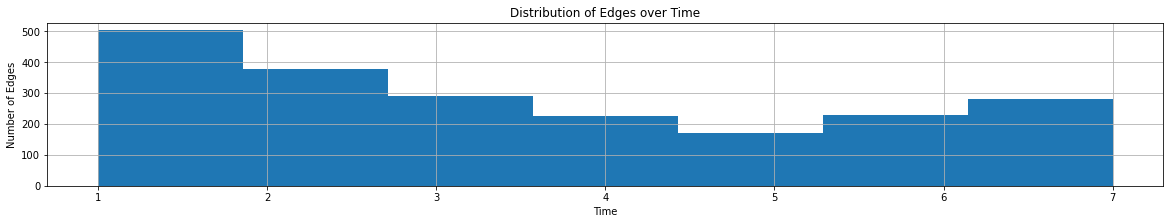

In [9]:
if HAS_EDGE_TIMESTAMP:
    EDGE_TIMESTAMPS.dropna().hist(
        bins=max(1, min(TIMESTAMP_BINS, len(EDGE_TIMESTAMPS.dropna().value_counts()))),
    )
    plt.title('Distribution of Edges over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Edges')
else:
    print('No edge timestamp data available')

# Global Statistics

In [10]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 113
Number of Edges: 2078
Density: 0.16419089759797725


In [11]:
degrees = pd.Series(G.degree(), index=G.vs['name'])

In [12]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 36.7787610619469
Median Degree: 18.0


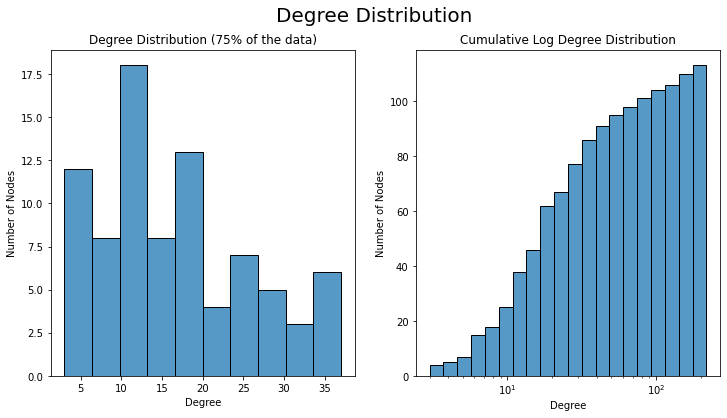

In [13]:
plot_explore_dual_histogram(
    series=degrees,
    title='Degree Distribution',
    title_short='Degree Distribution',
    xlabel='Degree',
    ylabel='Number of Nodes',
    normalize=False,
)
plt.show()

In [14]:
show_top_k_nodes(
    degrees,
    LABELS,
    title='Degree Nodes'
)

Top 10 Degree Nodes


,value,label
0,217,OBI-WAN
1,203,ANAKIN
2,194,C-3PO
3,159,PADME
4,156,EMPEROR
5,152,LUKE
6,142,LEIA
7,138,HAN
8,121,YODA
9,114,JAR JAR


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [32]:
# Use the largest connected component
G_cc = G.components("weak").giant()
G_cc.to_undirected()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [33]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.764
Diameter: 5


In [34]:
# Calculate the metrics
metrics_dict = {}

metrics_dict['degree_centrality'] = nx.degree_centrality(nx_G)
try:
    metrics_dict['betweenness_centrality'] = nx.betweenness_centrality(nx_Gu, k=BETWEENESS_K)
except Exception as e:
    print('Betweenness Centrality Error: {}'.format(e))
try:
    metrics_dict['eigenvector_centrality'] = nx.eigenvector_centrality(nx_Gu)
except Exception as e:
    print('Eigenvector Centrality Error: {}'.format(e))
metrics_dict['page_rank'] = nx.pagerank(nx_Gu)
metrics_dict['transitivity'] = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

NODE_STATS = pd.DataFrame(metrics_dict)
NODE_STATS.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,112.000000,112.000000,112.000000,112.000000,108.000000
mean,0.130309,0.004423,0.073453,0.008929,0.775653
std,0.121946,0.008792,0.059708,0.007156,0.230213
min,0.009009,0.000000,0.000867,0.001811,0.263842
25%,0.036036,0.000000,0.024043,0.003962,0.624412
50%,0.099099,0.000000,0.065722,0.006663,0.833333
75%,0.155405,0.004188,0.097806,0.010570,1.000000
max,0.540541,0.043554,0.249605,0.033541,1.000000


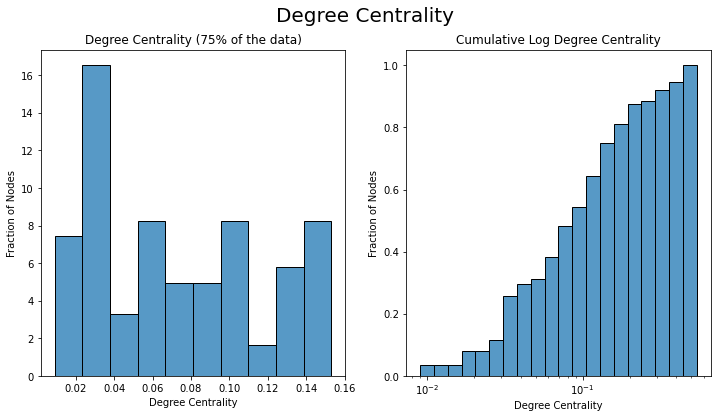

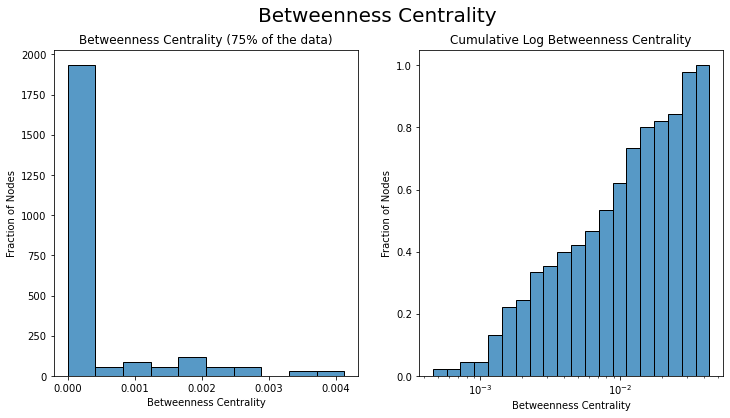

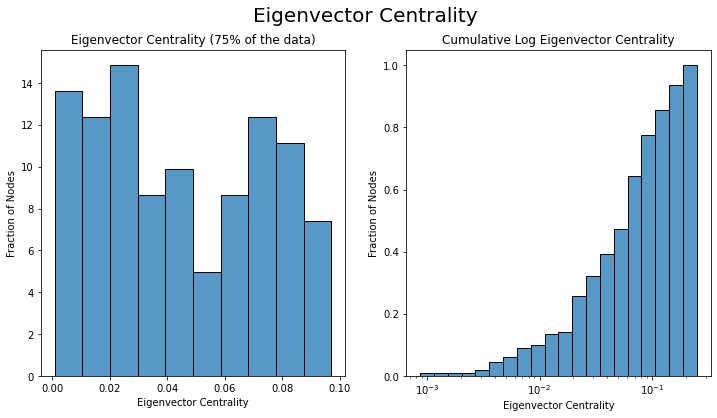

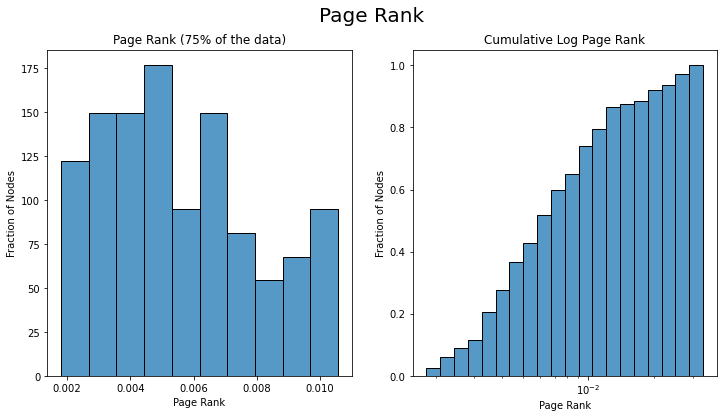

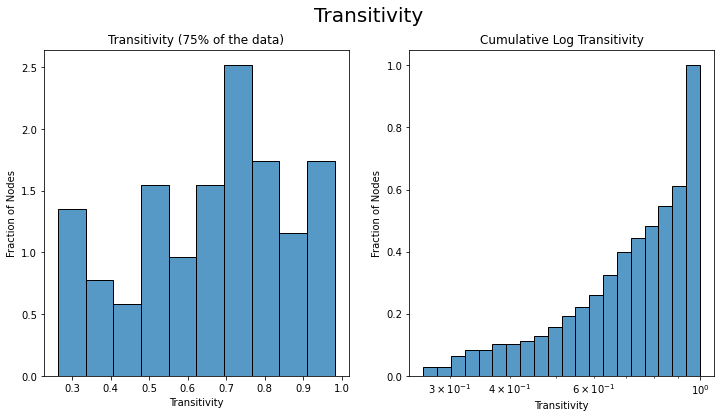

In [35]:
for col in NODE_STATS.columns:
    title = col.replace('_', ' ').title()
    data = NODE_STATS[col][np.isfinite(NODE_STATS[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [36]:
show_top_k_stacked_nodes(
    NODE_STATS,
    LABELS,
    title='Nodes by Statistic',
)

Top 10 Nodes by Statistic


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.540541,OBI-WAN,0.043554,OBI-WAN,0.249605,OBI-WAN,0.033541,OBI-WAN,1.0,ODD BALL
1,0.531532,R2-D2,0.033808,LUKE,0.249557,R2-D2,0.031960,R2-D2,1.0,BOUSHH
2,0.513514,ANAKIN,0.033634,POE,0.240250,ANAKIN,0.031696,ANAKIN,1.0,CLIEGG
3,0.459459,C-3PO,0.031171,EMPEROR,0.222863,C-3PO,0.027977,PADME,1.0,JOBAL
4,0.459459,PADME,0.028878,PADME,0.221048,PADME,0.027674,C-3PO,1.0,PLO KOON
5,0.441441,EMPEROR,0.028063,ANAKIN,0.216535,EMPEROR,0.027413,LUKE,1.0,CLONE COMMANDER CODY
6,0.405405,LUKE,0.027873,DARTH VADER,0.189464,YODA,0.027179,EMPEROR,1.0,GIDDEAN DANU
7,0.387387,LEIA,0.024712,HAN,0.179968,LEIA,0.024373,LEIA,1.0,CLONE COMMANDER GREE
8,0.360360,HAN,0.018892,KYLO REN,0.179653,LUKE,0.023490,HAN,1.0,CAMIE
9,0.324324,CHEWBACCA,0.015539,LEIA,0.171252,JAR JAR,0.020783,CHEWBACCA,1.0,MOTTI


## Connected Components Statistics

In [37]:
print(f'Number of Connected Components: {len(G.components("weak"))}')
largest_cc = G.components("weak").giant()
print(f'Size of the largest component: {largest_cc.vcount()}')

Number of Connected Components: 2
Size of the largest component: 112


Text(0.5, 1.0, 'Connected Components')

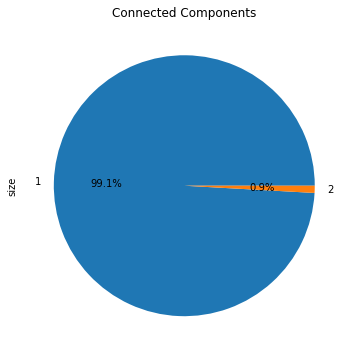

In [38]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components("weak"))], index=range(1,len(G.components("weak"))+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [39]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 1


,type,count,degree_avg,degree_median
Character,Character,113,36.778761,18.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

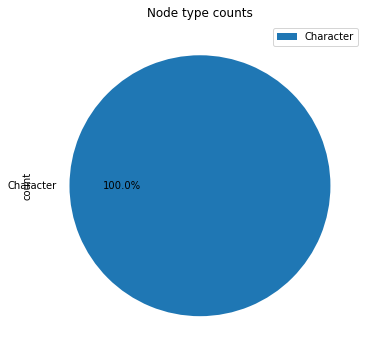

In [40]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

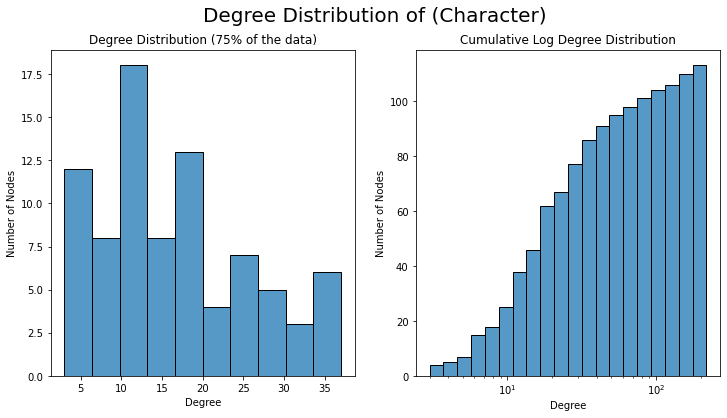

In [41]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [42]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    show_top_k_nodes(
        data,
        LABELS,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (Character)


,value,label
0,217,OBI-WAN
1,203,ANAKIN
2,194,C-3PO
3,159,PADME
4,156,EMPEROR
5,152,LUKE
6,142,LEIA
7,138,HAN
8,121,YODA
9,114,JAR JAR


### Edge Type Statistics

In [43]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 2


,type,count
INTERACTIONS,INTERACTIONS,958
MENTIONS,MENTIONS,1120


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

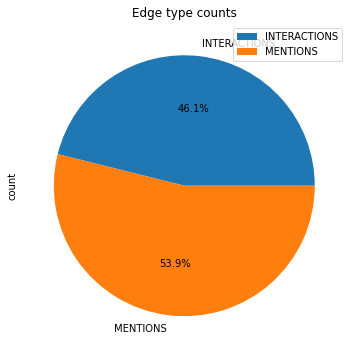

In [44]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))

## Node Type Connectivity Statistics

In [45]:
node_stats_by_type = {}

for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    names = set(nodes['name']) & set(NODE_STATS.index)

    node_stats_by_type[node_type] = NODE_STATS.loc[names]

In [46]:
for node_type in node_types:
    show_top_k_stacked_nodes(
        node_stats_by_type[node_type],
        LABELS,
        title=f'Nodes by Statistic for {node_type}',
    )

Top 10 Nodes by Statistic for Character


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.540541,OBI-WAN,0.043554,OBI-WAN,0.249605,OBI-WAN,0.033541,OBI-WAN,1.0,ODD BALL
1,0.531532,R2-D2,0.033808,LUKE,0.249557,R2-D2,0.031960,R2-D2,1.0,BOUSHH
2,0.513514,ANAKIN,0.033634,POE,0.240250,ANAKIN,0.031696,ANAKIN,1.0,CLIEGG
3,0.459459,C-3PO,0.031171,EMPEROR,0.222863,C-3PO,0.027977,PADME,1.0,JOBAL
4,0.459459,PADME,0.028878,PADME,0.221048,PADME,0.027674,C-3PO,1.0,PLO KOON
5,0.441441,EMPEROR,0.028063,ANAKIN,0.216535,EMPEROR,0.027413,LUKE,1.0,CLONE COMMANDER CODY
6,0.405405,LUKE,0.027873,DARTH VADER,0.189464,YODA,0.027179,EMPEROR,1.0,GIDDEAN DANU
7,0.387387,LEIA,0.024712,HAN,0.179968,LEIA,0.024373,LEIA,1.0,CLONE COMMANDER GREE
8,0.360360,HAN,0.018892,KYLO REN,0.179653,LUKE,0.023490,HAN,1.0,CAMIE
9,0.324324,CHEWBACCA,0.015539,LEIA,0.171252,JAR JAR,0.020783,CHEWBACCA,1.0,MOTTI


# Clustering

## No Clustering Modularity

In [47]:
n = G_cc.vcount()
print(f'Initial modularity: {G_cc.modularity(np.ones(n))}')

Initial modularity: 0.0


### Louvain

In [48]:
louvain = G_cc.community_multilevel()
print(f'Modularity after Louvain: {G_cc.modularity(louvain)}')
print(f'Number of communities: {len(louvain)}')

Modularity after Louvain: 0.3357209266880048
Number of communities: 4


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

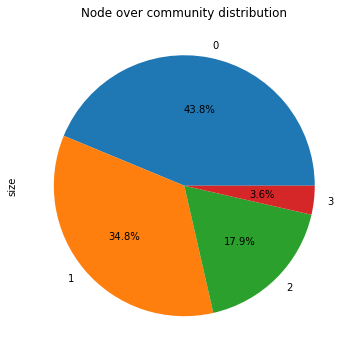

In [49]:
community_sizes = pd.Series(list(map(len, louvain)), name='size', index=range(len(louvain)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [50]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(louvain))):
    # Show top k nodes
    community_node_names = names.loc[louvain[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )

    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No node timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.459459,C-3PO,0.033808,LUKE,0.222863,C-3PO,0.027674,C-3PO,1.0,LIEUTENANT MITAKA
1,0.405405,LUKE,0.033634,POE,0.179968,LEIA,0.027413,LUKE,1.0,MAZ
2,0.387387,LEIA,0.027873,DARTH VADER,0.179653,LUKE,0.024373,LEIA,1.0,BOUSHH
3,0.360360,HAN,0.024712,HAN,0.161139,DARTH VADER,0.023490,HAN,1.0,OZZEL
4,0.324324,CHEWBACCA,0.018892,KYLO REN,0.158779,HAN,0.020783,CHEWBACCA,1.0,GOLD FIVE
5,0.306306,DARTH VADER,0.015539,LEIA,0.150572,CHEWBACCA,0.020202,DARTH VADER,1.0,NEEDA
6,0.216216,BOBA FETT,0.013705,CHEWBACCA,0.132741,BOBA FETT,0.013934,SNAP,1.0,DERLIN
7,0.216216,SNAP,0.013317,BOBA FETT,0.125990,JABBA,0.013582,BOBA FETT,1.0,MOTTI
8,0.198198,JABBA,0.009948,C-3PO,0.123242,SNAP,0.013447,POE,1.0,BALA-TIK
9,0.180180,LANDO,0.009173,WEDGE,0.119017,LANDO,0.013038,FINN,1.0,ADMIRAL STATURA


No node timestamp data available
Top 10 Nodes by Statistic for Community 1


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.540541,OBI-WAN,0.043554,OBI-WAN,0.249605,OBI-WAN,0.033541,OBI-WAN,1.000000,ORN FREE TAA
1,0.459459,PADME,0.031171,EMPEROR,0.221048,PADME,0.027977,PADME,1.000000,PK-4
2,0.441441,EMPEROR,0.028878,PADME,0.216535,EMPEROR,0.027179,EMPEROR,1.000000,SUN RIT
3,0.324324,YODA,0.015490,JAR JAR,0.189464,YODA,0.019981,JAR JAR,1.000000,VALORUM
4,0.324324,JAR JAR,0.014929,YODA,0.171252,JAR JAR,0.019422,YODA,1.000000,CLONE COMMANDER GREE
5,0.288288,QUI-GON,0.013029,COUNT DOOKU,0.156121,QUI-GON,0.017406,QUI-GON,1.000000,GIDDEAN DANU
6,0.234234,BAIL ORGANA,0.012993,RABE,0.144283,BAIL ORGANA,0.014136,BAIL ORGANA,1.000000,CLONE COMMANDER CODY
7,0.225225,MACE WINDU,0.011297,GENERAL GRIEVOUS,0.141833,MACE WINDU,0.013694,COUNT DOOKU,1.000000,PLO KOON
8,0.225225,COUNT DOOKU,0.009171,QUI-GON,0.139386,COUNT DOOKU,0.013587,NUTE GUNRAY,1.000000,TION MEDON
9,0.207207,NUTE GUNRAY,0.007993,BAIL ORGANA,0.113285,GENERAL GRIEVOUS,0.013452,MACE WINDU,0.969697,SENATOR ASK AAK


No node timestamp data available
Top 10 Nodes by Statistic for Community 2


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.531532,R2-D2,0.028063,ANAKIN,0.249557,R2-D2,0.031960,R2-D2,1.000000,SOLA
1,0.513514,ANAKIN,0.002293,WATTO,0.240250,ANAKIN,0.031696,ANAKIN,1.000000,RUWEE
2,0.153153,SHMI,0.000000,KITSTER,0.099857,SHMI,0.009607,SHMI,1.000000,WALD
3,0.144144,WATTO,0.000000,BERU,0.096658,OWEN,0.009285,WATTO,1.000000,JIRA
4,0.126126,OWEN,0.000000,WALD,0.094157,WATTO,0.008195,OWEN,1.000000,ODD BALL
5,0.126126,KITSTER,0.000000,ODD BALL,0.083426,KITSTER,0.008161,KITSTER,1.000000,BRAVO THREE
6,0.117117,BERU,0.000000,OWEN,0.081950,BERU,0.007783,BERU,1.000000,BRAVO TWO
7,0.108108,RIC OLIE,0.000000,JOBAL,0.079159,SEBULBA,0.007585,RIC OLIE,1.000000,JOBAL
8,0.108108,SEBULBA,0.000000,CLIEGG,0.070611,FODE/BEED,0.007059,SEBULBA,1.000000,CLIEGG
9,0.099099,FODE/BEED,0.000000,RUWEE,0.069811,RIC OLIE,0.006589,FODE/BEED,0.981818,FODE/BEED


No node timestamp data available
Top 10 Nodes by Statistic for Community 3


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.072072,JESS,0.0,NIV LEK,0.023214,JESS,0.006880,JESS,1.000000,NIV LEK
1,0.036036,NIV LEK,0.0,JESS,0.004121,NIV LEK,0.004596,NIV LEK,1.000000,ELLO ASTY
2,0.036036,ELLO ASTY,0.0,ELLO ASTY,0.004121,ELLO ASTY,0.004596,ELLO ASTY,1.000000,YOLO ZIFF
3,0.036036,YOLO ZIFF,0.0,YOLO ZIFF,0.004121,YOLO ZIFF,0.004596,YOLO ZIFF,0.571429,JESS


No node timestamp data available


### Label Propagation

In [51]:
label_prop = G_cc.community_label_propagation()
print(f'Modularity after Label Propagation: {G_cc.modularity(label_prop)}')
print(f'Number of communities: {len(label_prop)}')

Modularity after Label Propagation: 0.0
Number of communities: 1


<AxesSubplot:title={'center':'Node over community distribution'}, ylabel='size'>

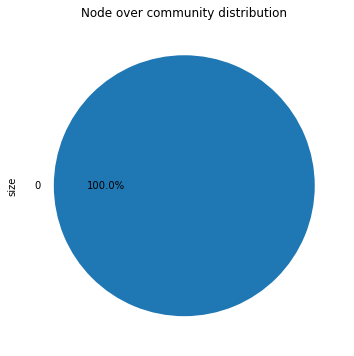

In [52]:
community_sizes = pd.Series(list(map(len, label_prop)), name='size', index=range(len(label_prop)))
community_sizes.sort_values(ascending=False).head(30).plot.pie(y='count', autopct='%1.1f%%', title='Node over community distribution', figsize=(6,6))

In [53]:
names = pd.Series(G_cc.vs['name'], index=range(G_cc.vcount()))

k = 6
for community in range(min(k, len(label_prop))):
    # Show top k nodes
    community_node_names = names.loc[label_prop[community]]
    community_node_stats = NODE_STATS.loc[community_node_names]
    show_top_k_stacked_nodes(
        community_node_stats,
        LABELS,
        title=f'Nodes by Statistic for Community {community}',
    )


    if HAS_NODE_TIMESTAMP:
        # Show their timestamp distribution
        NODE_TIMESTAMPS[community_node_names].dropna().hist(bins=TIMESTAMP_BINS)
        plt.title('Distribution of Nodes over Time')
        plt.xlabel('Time')
        plt.ylabel('Number of Nodes')
        plt.show()
    else:
        print('No timestamp data available')

Top 10 Nodes by Statistic for Community 0


,Degree Centrality,Degree Centrality Item,Betweenness Centrality,Betweenness Centrality Item,Eigenvector Centrality,Eigenvector Centrality Item,Page Rank,Page Rank Item,Transitivity,Transitivity Item
0,0.540541,OBI-WAN,0.043554,OBI-WAN,0.249605,OBI-WAN,0.033541,OBI-WAN,1.0,ODD BALL
1,0.531532,R2-D2,0.033808,LUKE,0.249557,R2-D2,0.031960,R2-D2,1.0,BOUSHH
2,0.513514,ANAKIN,0.033634,POE,0.240250,ANAKIN,0.031696,ANAKIN,1.0,CLIEGG
3,0.459459,C-3PO,0.031171,EMPEROR,0.222863,C-3PO,0.027977,PADME,1.0,JOBAL
4,0.459459,PADME,0.028878,PADME,0.221048,PADME,0.027674,C-3PO,1.0,PLO KOON
5,0.441441,EMPEROR,0.028063,ANAKIN,0.216535,EMPEROR,0.027413,LUKE,1.0,CLONE COMMANDER CODY
6,0.405405,LUKE,0.027873,DARTH VADER,0.189464,YODA,0.027179,EMPEROR,1.0,GIDDEAN DANU
7,0.387387,LEIA,0.024712,HAN,0.179968,LEIA,0.024373,LEIA,1.0,CLONE COMMANDER GREE
8,0.360360,HAN,0.018892,KYLO REN,0.179653,LUKE,0.023490,HAN,1.0,CAMIE
9,0.324324,CHEWBACCA,0.015539,LEIA,0.171252,JAR JAR,0.020783,CHEWBACCA,1.0,MOTTI


No timestamp data available
